Difference from v2 is that here, can I use a final extra layer to turn edt into segment masks?

#####  Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

from scipy import ndimage

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


##### Filepaths

In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
models_path = data_dir / "models"
train_images_crops = data_dir/"train_crops"
mask_dir_edt = data_dir /"mask_full_size_edt"
train_mask_crops = data_dir/"mask_crops_single_channel"
label_dir = data_dir/"train"/"labels"
mask_crops_edt = data_dir/"mask_crops_edt"
test_crops = data_dir/"test_crops"

#### sanity check edt_mask.

7 0 [0 1 2 3 4 5 6 7]


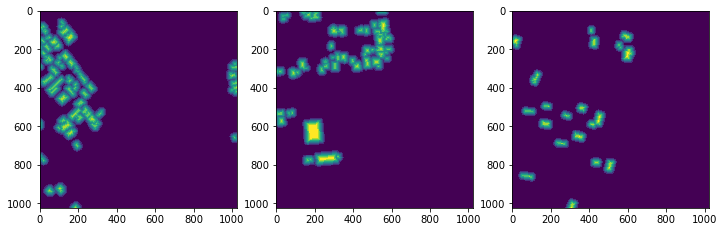

In [3]:
# run create_edt_mask.py
# sanity check:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir_edt = data_dir /"mask_full_size_edt"
sample_files = np.array(mask_dir_edt.ls())[np.random.randint(0, 100, 3)]

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axs = ax.ravel()
for idx, fname in enumerate(sample_files):    
    img = np.array(PIL.Image.open(fname))
    axs[idx].imshow(img)

print(img.max(), img.min(), np.unique(img))

#### Sanity check crops

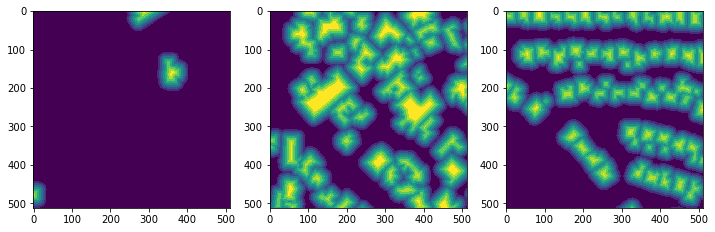

In [3]:
sample_files = np.array(mask_crops_edt.ls())[np.random.randint(0, 1000, 3)]

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axs = ax.ravel()
for idx, fname in enumerate(sample_files):    
    img = np.array(PIL.Image.open(fname))
    axs[idx].imshow(img)


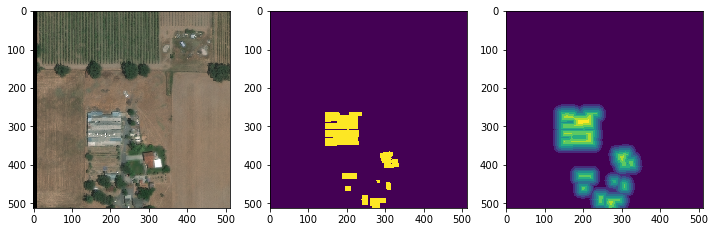

In [4]:
fname = "mask_santa-rosa-wildfire_00000136_pre_disaster_1.png"
a = np.array(PIL.Image.open(mask_crops_edt /fname))
b = np.array(PIL.Image.open(train_mask_crops/fname.replace("disaster_", "disaster._")))
c = np.array(PIL.Image.open(train_images_crops/fname.replace('mask', 'rgb').replace("disaster_", "disaster._")))

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axs = ax.ravel()
axs[0].imshow(c)
axs[1].imshow(b/b.max() * 255)
axs[2].imshow(a/a.max() * 255)
# train_mask_crops

#### attempt at multitask net fastai (single head)

In [5]:
unique_img_ids = list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() ]))
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [4]:
def is_valid_func(fname):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)
    
    

In [7]:

size=256
bs=16

class MultiClassSegList(SegmentationLabelList):
    def open(self, id_rles):
        image_id, rles = id_rles[0], id_rles[1:]
        shape = open_image(self.path/image_id).shape[-2:]       
        final_mask = torch.zeros((1, *shape))
        for k, rle in enumerate(rles):
            if isinstance(rle, str):
                mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
                final_mask += (k+1)*mask
        return ImageSegment(final_mask)
    
    
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom


class SegLabelListEdt(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=False, convert_mode='I')

class SegItemListEdt(SegmentationItemList):
    _label_cls = SegLabelListEdt
    
segmentation_labels = (
    SegItemListCustom.from_folder(train_images_crops)
        .filter_by_func(lambda fname: 'pre_' in fname.name)
      .split_by_valid_func(is_valid_func)
       .label_from_func(lambda fname: train_mask_crops / fname.name.replace("rgb", "mask"), classes=["void", "building"])
)
edt_labels = (
    SegItemListEdt.from_folder(train_images_crops)
        .filter_by_func(lambda fname: 'pre_' in fname.name)
      .split_by_valid_func(is_valid_func)
       .label_from_func(lambda fname: mask_crops_edt / fname.name.replace("rgb", "mask").replace("disaster._", "disaster_"),
                        classes=np.arange(0, 9)
        )
)

In [8]:
accuracy_pixel=partial(foreground_acc, void_code=0)
f1_score = partial(fbeta, thresh=0.2, beta = 1)

wd =1e-2

metrics = [accuracy_pixel,dice]

multitask_project = {
    'segmentation': {
        'label_lists': segmentation_labels,
        'metric': metrics
    },
    'edt': {
        'label_lists': edt_labels,
        'metric': metrics
    }
}


In [7]:
a = torch.rand(size=(8, 9, 99, 99))
b = a[:, :5, ...].sum(dim=1).unsqueeze(dim=1)
c = a[:, 5:, ...].sum(dim=1).unsqueeze(dim=1)
print(a[:, :5, ...].sum(dim=1).unsqueeze(dim=1).shape, a[:, 5:, ...].sum(dim=1).unsqueeze(dim=1).shape)
print(torch.cat((b, c), dim=1).shape)

torch.Size([8, 1, 99, 99]) torch.Size([8, 1, 99, 99])
torch.Size([8, 2, 99, 99])


#### Single model-- monitor and compare thresholded output

In [8]:
class BCEDice(nn.Module):

    def __init__(self, dice=0.5, bce=0.5):
        super(BCEDice, self).__init__()
        self.dice = dice
        self.bce = bce

    def forward(self, input, target, **kwargs):
        logits=input[:,1,:,:].float()
        labels = target.squeeze(1).float()
                     
        bce_dice = BCEDiceLoss(dice_weight=self.dice, bce_weight=self.bce)
        
        total_loss = bce_dice(logits, labels) #+ 0.2 * lovaz_loss(logit, target)
        return total_loss


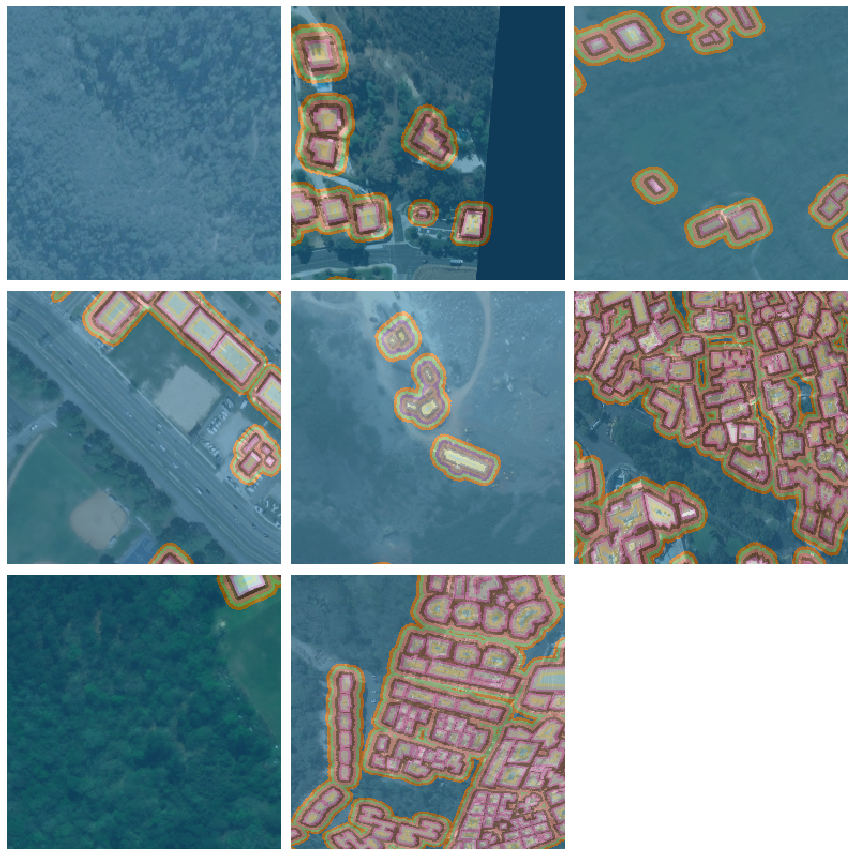

In [17]:
bs = 8
size=256
data_edt = (edt_labels.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
            .add_test_folder(test_crops, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data_edt.show_batch()


In [10]:
def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
                             dtype=torch.uint8,
                             device=indices.device)
#         return onehot.scatter_(1, indices.int().unsqueeze(1), 1)
        return onehot.scatter_(1, indices.long().unsqueeze(1), 1)
    
def multiclass_dice(input:Tensor, targs:Tensor, num_classes, eps:float=1e-8)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."

    targs = to_onehot(targs, num_classes=num_classes).squeeze()
    input = to_onehot(input.argmax(dim=1), num_classes=num_classes).squeeze()
#     print(input.shape, targs.shape)
    intersect = (input * targs).sum(dim=1).float()
#     print(intersect.shape)
    union = (input+targs).sum(dim=1).float()
#     print(intersect.shape(), union.shape(), intersect.sum(), union.sum())
    l = 2. * intersect / (union + eps)

    return l.mean()

def accuracy_segment(inputs:Tensor, targets:Tensor):
    void_code=0
    targets_binarized = (targets >=5).int().type(targets.dtype)


    inputs_binarized_0 = inputs[:, :5, ...].sum(dim=1).unsqueeze(dim=1)
    inputs_binarized_1 = inputs[:, 5:, ...].sum(dim=1).unsqueeze(dim=1)

    inputs_binarized = torch.cat((inputs_binarized_0, inputs_binarized_1), dim=1)

    #     print(inputs_binarized.shape, targets_binarized.shape)
    targets_binarized = targets_binarized.squeeze(1)
    mask = targets_binarized != void_code
#     print(mask.shape, targets_binarized.shape, )
    acc = (inputs_binarized.argmax(dim=1)[mask]==targets_binarized[mask]).float().mean()
    return acc


def dice_segment(inputs:Tensor, targets:Tensor):
    void_code=0
    targets_binarized = (targets >=5).int().type(targets.dtype)


    inputs_binarized_0 = inputs[:, :5, ...].sum(dim=1).unsqueeze(dim=1)
    inputs_binarized_1 = inputs[:, 5:, ...].sum(dim=1).unsqueeze(dim=1)

    inputs_binarized = torch.cat((inputs_binarized_0, inputs_binarized_1), dim=1)
    
    return dice(inputs_binarized, targets_binarized)
    

In [12]:

class CombinedLoss(nn.Module):

    def __init__(self, frac_segment=0.5, frac_edt=0.5):
        super(CombinedLoss, self).__init__()
        self.frac_segment = frac_segment
        self.frac_edt = frac_edt

    def forward(self, inputs, targets, **kwargs):
        #torch.Size([8, 9, 256, 256]) torch.Size([8, 1, 256, 256])
        ce_loss_edt = CrossEntropyFlat(axis=1)(inputs, targets)
        
        inputs_binarized_0 = inputs[:, :5, ...].sum(dim=1).unsqueeze(dim=1)
        inputs_binarized_1 = inputs[:, 5:, ...].sum(dim=1).unsqueeze(dim=1)

        inputs_binarized = torch.cat((inputs_binarized_0, inputs_binarized_1), dim=1)
        targets_binarized = (targets >=5).int().type(targets.dtype)


        inputs_binarized = torch.cat((inputs_binarized_0, inputs_binarized_1), dim=1)


#         inputs_binarized = (inputs.argmax(dim=1) >=5).unsqueeze(dim=1).int()
        targets_binarized = (targets >=5).type(torch.int64)
#         one_hot_inputs = to_onehot(inputs_binarized.squeeze(), num_classes=2).type(torch.int64)
        
        
#         print(one_hot_inputs.dtype, targets_binarized.dtype)
        ce_loss_seg =  CrossEntropyFlat(axis=1)(inputs_binarized, targets_binarized)
        
        
        total_loss = self.frac_segment * ce_loss_seg + \
                self. frac_edt * ce_loss_edt
        return total_loss

In [18]:
accuracy_pixel=partial(foreground_acc, void_code=0)
dice_custom = partial(multiclass_dice, num_classes=9)
metrics=[accuracy_pixel,dice_custom, accuracy_segment]

learn_edt = unet_learner(data_edt, models.resnet34, metrics=metrics)
learn_edt.loss_func= CombinedLoss()
learn_edt.to_fp16();
learn_edt.metrics = metrics



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


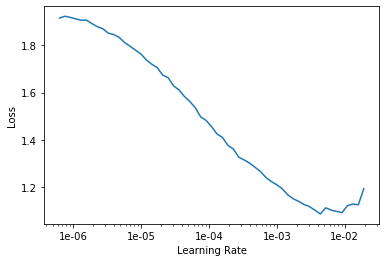

In [59]:
learn_edt.lr_find()
learn_edt.recorder.plot(skip_end=1);

In [80]:
learn_edt.fit_one_cycle(2, max_lr=5e-4)

In [82]:
metrics=[accuracy_pixel,dice_custom, accuracy_segment, dice_segment]
learn_edt.metrics = metrics
learn_edt.fit_one_cycle(2, max_lr=5e-4)

In [84]:
learn_edt.model_dir = models_path
learn_edt.save('21Dec-segment_edt_v1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


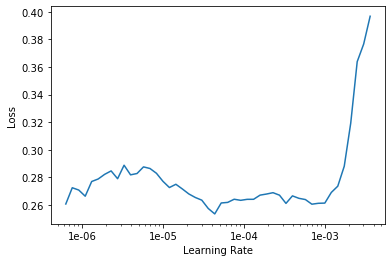

In [85]:
learn_edt.unfreeze()
learn_edt.lr_find()

learn_edt.recorder.plot()

In [86]:
learn_edt.fit_one_cycle(2, max_lr=1e-6)

In [88]:
learn_edt.save('21Dec-segment_edt_v1_unfrozen')
callbacks=[SaveModelCallback(learn_edt, every='improvement', monitor='dice_segment', name='21Dec-segment_edt_v1_unfrozen'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn_edt, patience=1, monitor='dice_segment')
          ]

learn_edt.fit_one_cycle(5, max_lr=1e-6, callbacks=callbacks)

Better model found at epoch 0 with dice_segment value: 0.7109289765357971.
Better model found at epoch 1 with dice_segment value: 0.7128604054450989.
Better model found at epoch 2 with dice_segment value: 0.713772714138031.
Better model found at epoch 3 with dice_segment value: 0.7138456106185913.


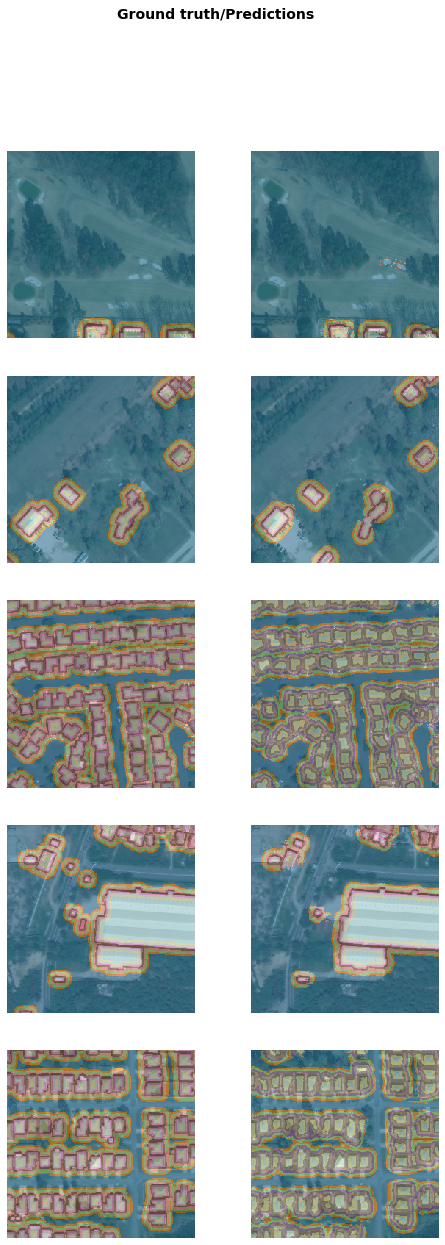

In [89]:
learn_edt.show_results()

In [90]:
preds_valid, y, loss = learn_edt.get_preds(ds_type=DatasetType.Valid, with_loss=True)

In [14]:
def edt_to_segment(inputs):
    inputs_binarized_0 = inputs[:, :5, ...].sum(dim=1).unsqueeze(dim=1)
    inputs_binarized_1 = inputs[:, 5:, ...].sum(dim=1).unsqueeze(dim=1)

    inputs_binarized = torch.cat((inputs_binarized_0, inputs_binarized_1), dim=1)
    
    return inputs_binarized

In [94]:
results = torch.max(edt_to_segment(preds_valid), dim=1).indices.numpy()

In [107]:
ground_truth_valid = (y >=5).int().numpy().squeeze()
ground_truth_valid.shape

(3176, 256, 256)

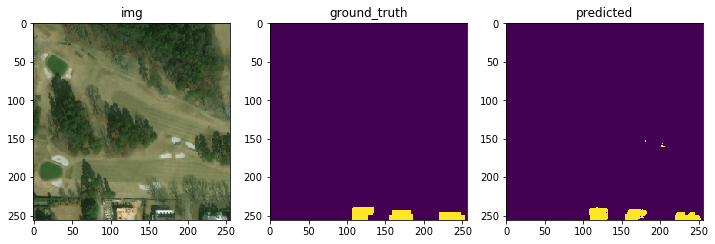

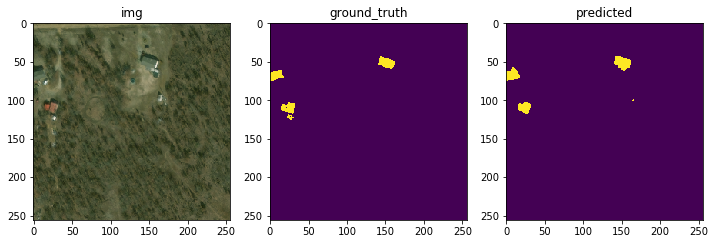

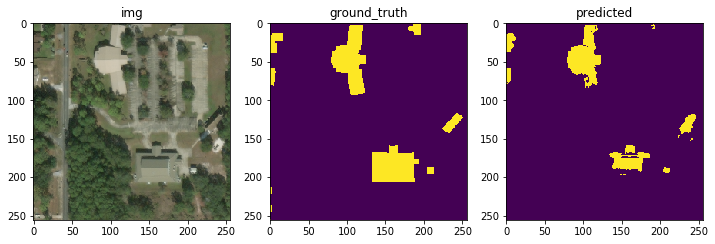

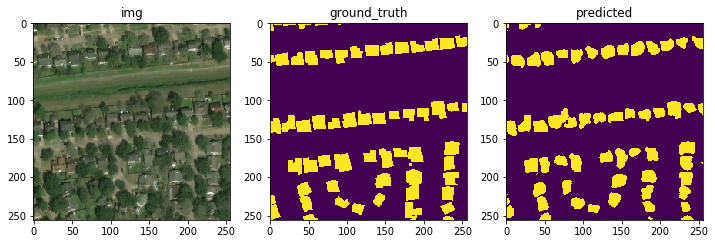

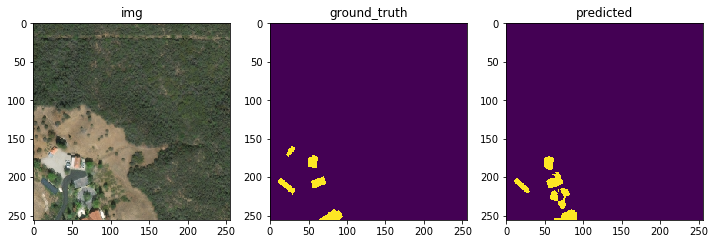

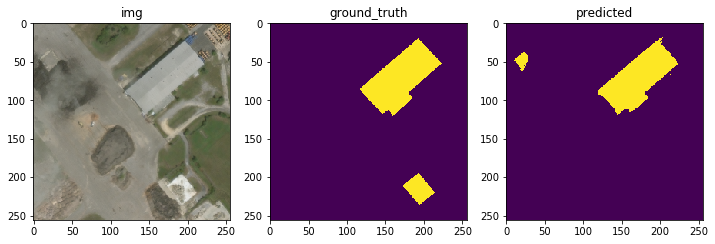

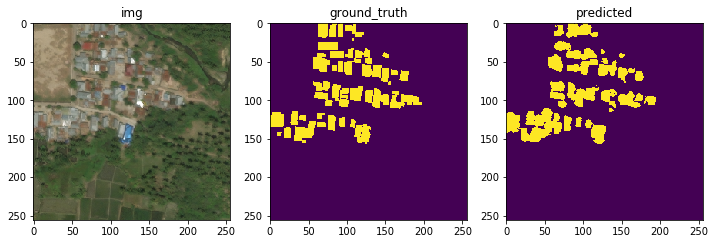

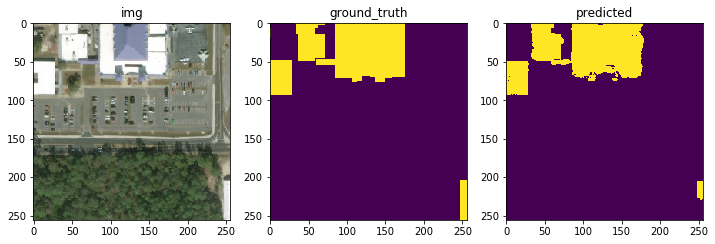

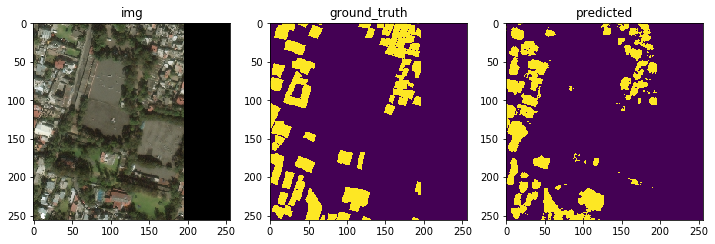

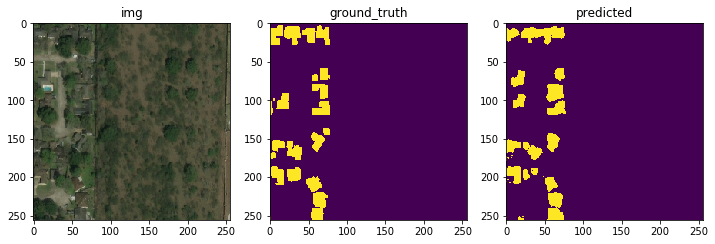

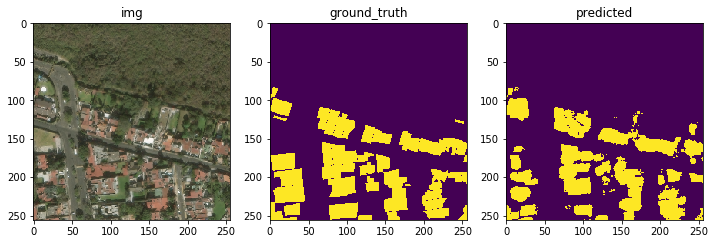

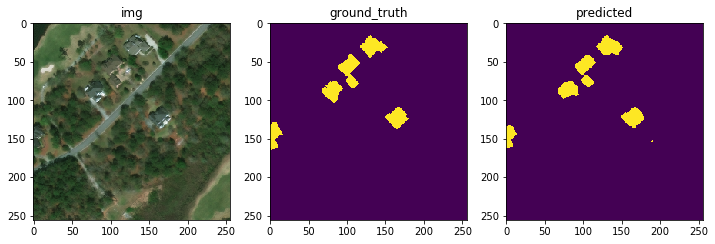

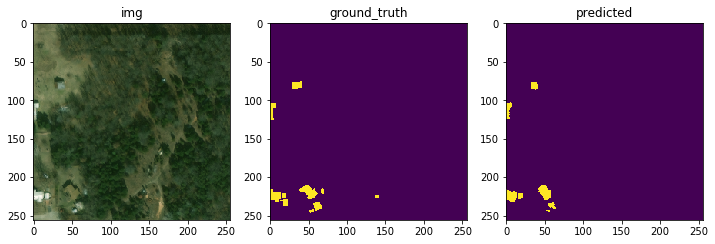

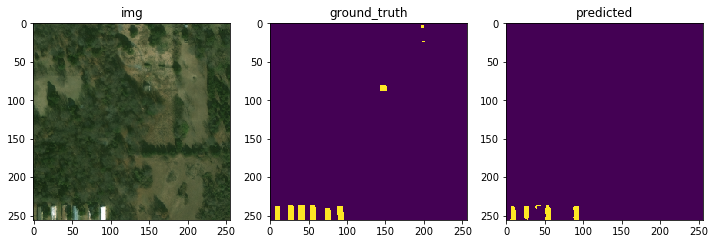

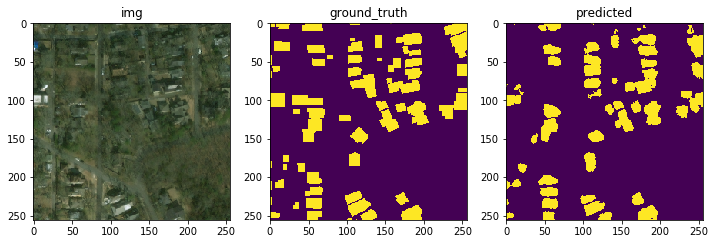

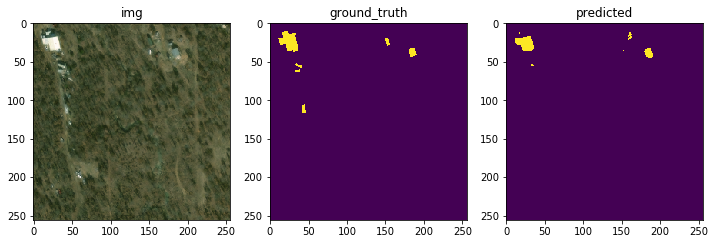

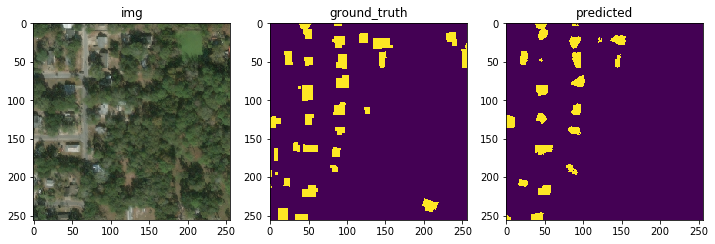

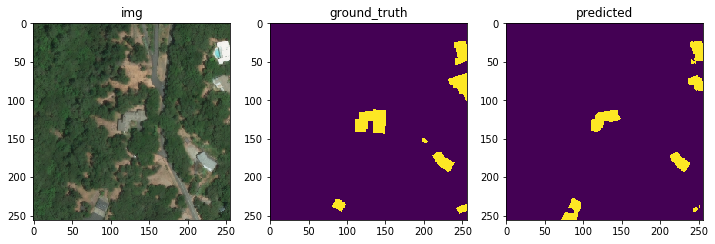

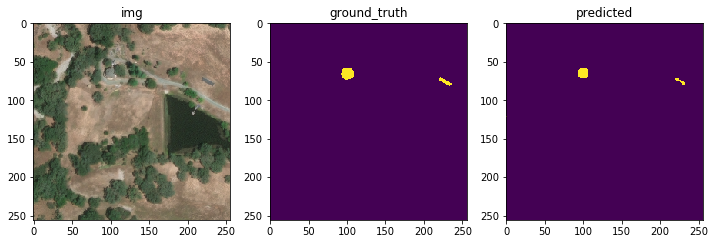

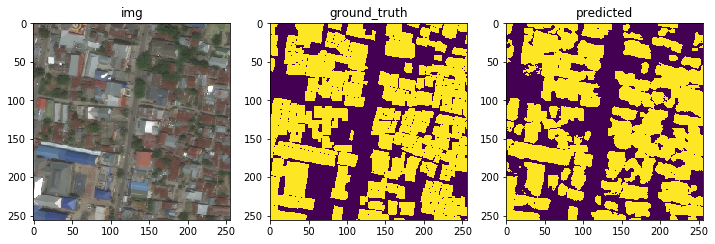

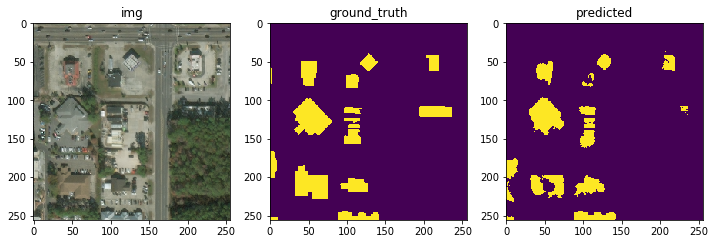

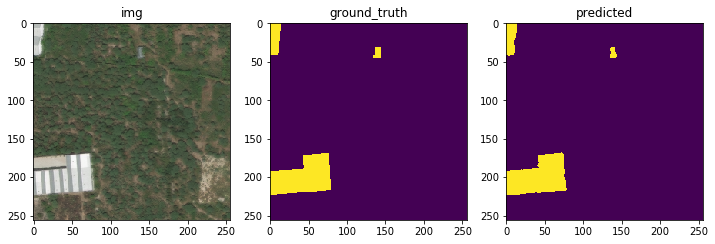

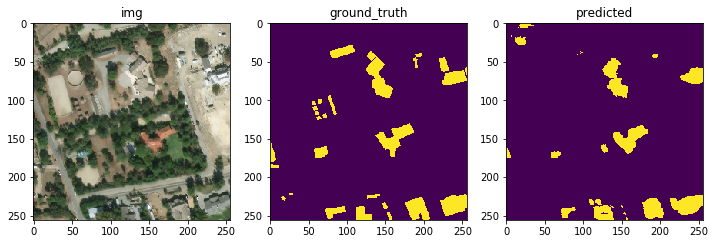

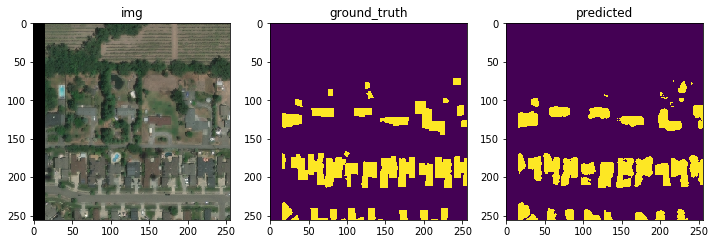

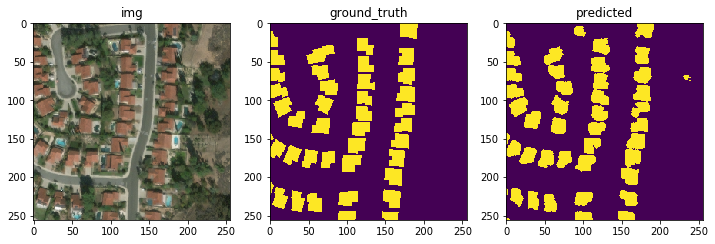

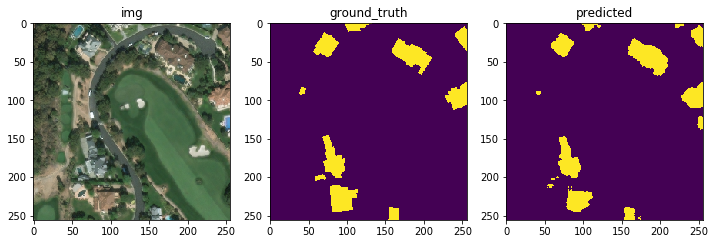

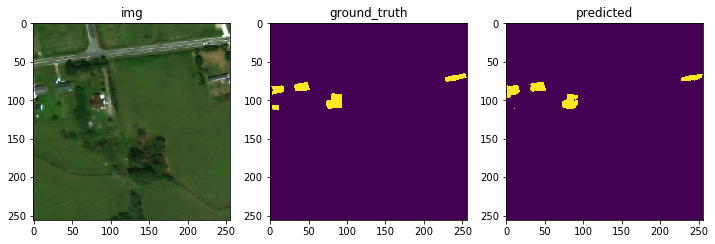

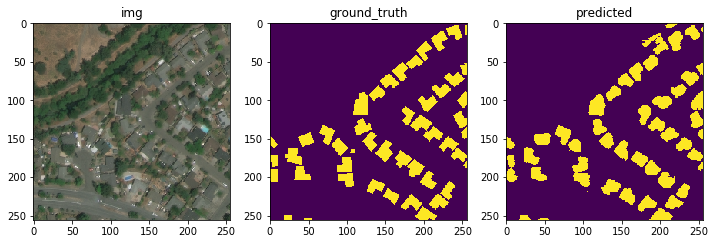

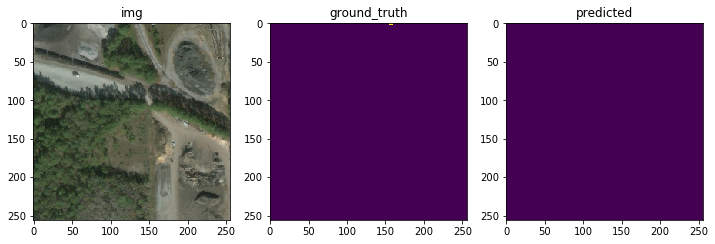

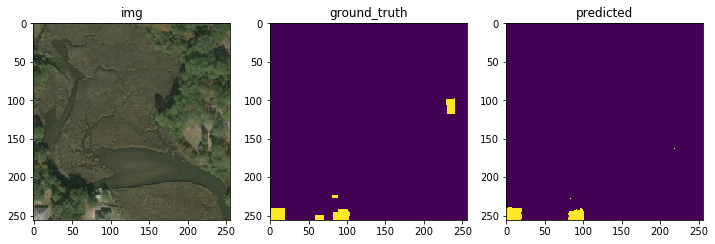

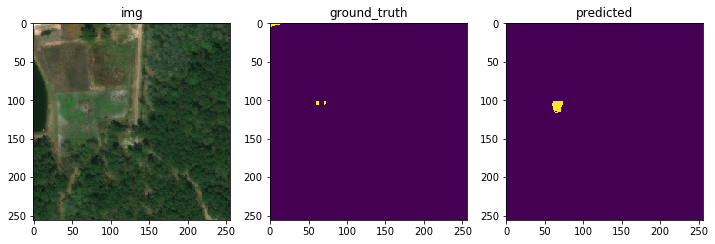

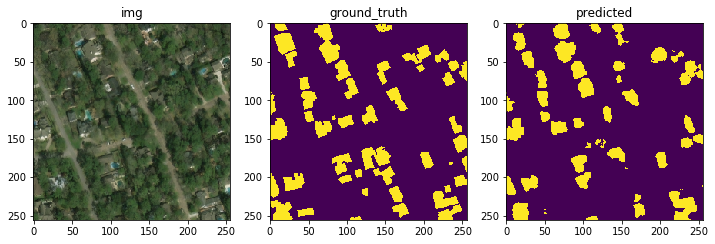

In [112]:
for idx in range(0, len(ground_truth_valid), 100):
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    axs = ax.ravel()
    axs[0].imshow(learn_edt.data.valid_ds[idx][0].data.permute(1,2,0).numpy())
    axs[0].set_title('img')
    axs[1].imshow(ground_truth_valid[idx])
    axs[1].set_title('ground_truth');
    axs[2].imshow(results[idx])
    axs[2].set_title('predicted');

In [19]:
learn_edt.model_dir = models_path
learn_edt.load('21Dec-segment_edt_v1_unfrozen');


In [63]:
test_mask_crops_edt = data_dir/"test_mask_crops_edt"
test_mask_crops_edt.mkdir(exist_ok=True)

In [64]:
test_crops_filenames = [test_mask_crops_edt/x.name.replace('rgb', 'mask') for x in data_edt.test_dl.items]
test_iterator = iter(data_edt.test_dl)
i = 0
print("starting")
for batch in test_iterator:
    print(f"start_img {i}")
    batch_preds = learn_edt.pred_batch(batch=batch)
    segment_results = torch.max(edt_to_segment(batch_preds), dim=1).indices.numpy()
    filenames = test_crops_filenames[i: i+ segment_results.shape[0]]
    
    assert segment_results.shape[0] == len(filenames)
    
    for idx, img_arr in enumerate(segment_results):
        PIL.Image.fromarray(img_arr.astype(np.uint8)).save(filenames[idx], mode='L')
    i += segment_results.shape[0]
# res = [to_float(torch.cat(o).cpu()) for o in
#            zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False, n_batch=n_batch))]

starting
start_img 0
start_img 8
start_img 16
start_img 24
start_img 32
start_img 40
start_img 48
start_img 56
start_img 64
start_img 72
start_img 80
start_img 88
start_img 96
start_img 104
start_img 112
start_img 120
start_img 128
start_img 136
start_img 144
start_img 152
start_img 160
start_img 168
start_img 176
start_img 184
start_img 192
start_img 200
start_img 208
start_img 216
start_img 224
start_img 232
start_img 240
start_img 248
start_img 256
start_img 264
start_img 272
start_img 280
start_img 288
start_img 296
start_img 304
start_img 312
start_img 320
start_img 328
start_img 336
start_img 344
start_img 352
start_img 360
start_img 368
start_img 376
start_img 384
start_img 392
start_img 400
start_img 408
start_img 416
start_img 424
start_img 432
start_img 440
start_img 448
start_img 456
start_img 464
start_img 472
start_img 480
start_img 488
start_img 496
start_img 504
start_img 512
start_img 520
start_img 528
start_img 536
start_img 544
start_img 552
start_img 560
start_img 56

start_img 4440
start_img 4448
start_img 4456
start_img 4464
start_img 4472
start_img 4480
start_img 4488
start_img 4496
start_img 4504
start_img 4512
start_img 4520
start_img 4528
start_img 4536
start_img 4544
start_img 4552
start_img 4560
start_img 4568
start_img 4576
start_img 4584
start_img 4592
start_img 4600
start_img 4608
start_img 4616
start_img 4624
start_img 4632
start_img 4640
start_img 4648
start_img 4656
start_img 4664
start_img 4672
start_img 4680
start_img 4688
start_img 4696
start_img 4704
start_img 4712
start_img 4720
start_img 4728
start_img 4736
start_img 4744
start_img 4752
start_img 4760
start_img 4768
start_img 4776
start_img 4784
start_img 4792
start_img 4800
start_img 4808
start_img 4816
start_img 4824
start_img 4832
start_img 4840
start_img 4848
start_img 4856
start_img 4864
start_img 4872
start_img 4880
start_img 4888
start_img 4896
start_img 4904
start_img 4912
start_img 4920
start_img 4928
start_img 4936
start_img 4944
start_img 4952
start_img 4960
start_img 

start_img 8840
start_img 8848
start_img 8856
start_img 8864
start_img 8872
start_img 8880
start_img 8888
start_img 8896
start_img 8904
start_img 8912
start_img 8920
start_img 8928
start_img 8936
start_img 8944
start_img 8952
start_img 8960
start_img 8968
start_img 8976
start_img 8984
start_img 8992
start_img 9000
start_img 9008
start_img 9016
start_img 9024
start_img 9032
start_img 9040
start_img 9048
start_img 9056
start_img 9064
start_img 9072
start_img 9080
start_img 9088
start_img 9096
start_img 9104
start_img 9112
start_img 9120
start_img 9128
start_img 9136
start_img 9144
start_img 9152
start_img 9160
start_img 9168
start_img 9176
start_img 9184
start_img 9192
start_img 9200
start_img 9208
start_img 9216
start_img 9224
start_img 9232
start_img 9240
start_img 9248
start_img 9256
start_img 9264
start_img 9272
start_img 9280
start_img 9288
start_img 9296
start_img 9304
start_img 9312
start_img 9320
start_img 9328
start_img 9336
start_img 9344
start_img 9352
start_img 9360
start_img 

start_img 13032
start_img 13040
start_img 13048
start_img 13056
start_img 13064
start_img 13072
start_img 13080
start_img 13088
start_img 13096
start_img 13104
start_img 13112
start_img 13120
start_img 13128
start_img 13136
start_img 13144
start_img 13152
start_img 13160
start_img 13168
start_img 13176
start_img 13184
start_img 13192
start_img 13200
start_img 13208
start_img 13216
start_img 13224
start_img 13232
start_img 13240
start_img 13248
start_img 13256
start_img 13264
start_img 13272
start_img 13280
start_img 13288
start_img 13296
start_img 13304
start_img 13312
start_img 13320
start_img 13328
start_img 13336
start_img 13344
start_img 13352
start_img 13360
start_img 13368
start_img 13376
start_img 13384
start_img 13392
start_img 13400
start_img 13408
start_img 13416
start_img 13424
start_img 13432
start_img 13440
start_img 13448
start_img 13456
start_img 13464
start_img 13472
start_img 13480
start_img 13488
start_img 13496
start_img 13504
start_img 13512
start_img 13520
start_im

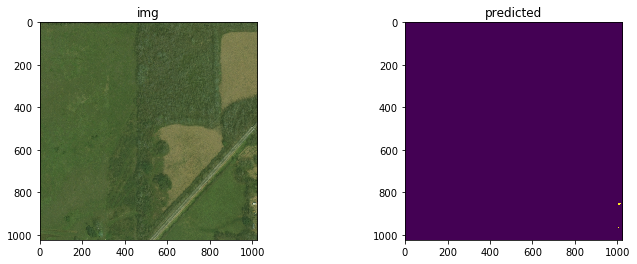

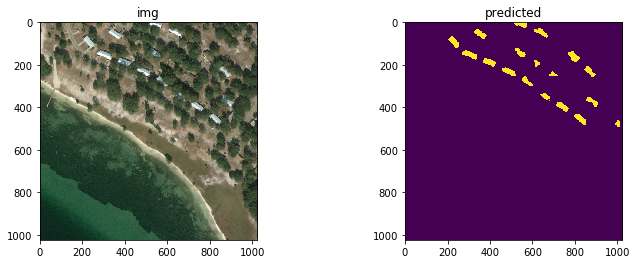

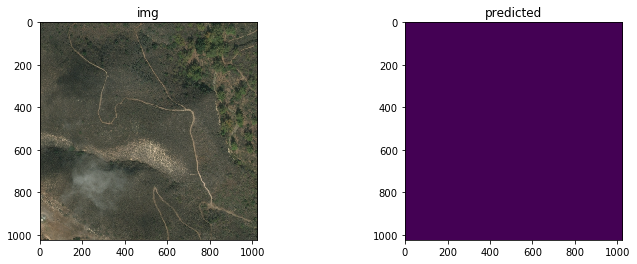

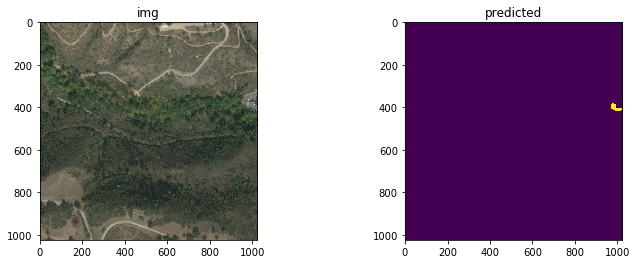

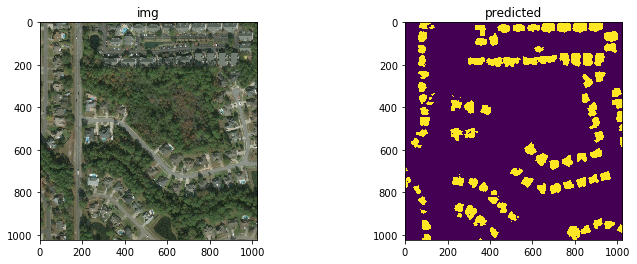

In [70]:
test_imgs = [x for x in (data_dir/"test"/"images").ls() if 'pre_' in x.name]
edt_masks = [data_dir / "test_masks_edt"/x.name.replace('pre', 'localization').replace('.png', '_prediction.png') for x in test_imgs]

for idx in range(5):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    axs = ax.ravel()
    axs[0].imshow(np.array(PIL.Image.open(test_imgs[idx])))
    axs[0].set_title('img')
    axs[1].imshow(np.array(PIL.Image.open(edt_masks[idx])))
    axs[1].set_title('predicted');

In [68]:
(data_dir / "test_masks_edt").ls()[0]

PosixPath('/media/wwymak/Storage/xView2/test_masks_edt/test_localization_00923_prediction.png')

In [116]:

class CombinedLossFocal(nn.Module):

    def __init__(self, frac_segment=0.5, frac_edt=0.5):
        super(CombinedLossFocal, self).__init__()
        self.frac_segment = frac_segment
        self.frac_edt = frac_edt

    def forward(self, inputs, targets, **kwargs):
        #torch.Size([8, 9, 256, 256]) torch.Size([8, 1, 256, 256])
        ce_loss_edt = CrossEntropyFlat(axis=1)(inputs, targets)
        
        inputs_binarized_0 = inputs[:, :5, ...].sum(dim=1).unsqueeze(dim=1)
        inputs_binarized_1 = inputs[:, 5:, ...].sum(dim=1).unsqueeze(dim=1)

        inputs_binarized = torch.cat((inputs_binarized_0, inputs_binarized_1), dim=1)
        targets_binarized = (targets >=5).int().type(targets.dtype)


        inputs_binarized = torch.cat((inputs_binarized_0, inputs_binarized_1), dim=1)


#         inputs_binarized = (inputs.argmax(dim=1) >=5).unsqueeze(dim=1).int()
        targets_binarized = (targets >=5).type(torch.int64)
#         one_hot_inputs = to_onehot(inputs_binarized.squeeze(), num_classes=2).type(torch.int64)
        
        
#         print(one_hot_inputs.dtype, targets_binarized.dtype)
        ce_loss_seg =  CrossEntropyFlat(axis=1)(inputs_binarized, targets_binarized)
        
        focal_loss = FocalLossMultiClass(gamma=2., alpha=0.25)
        
        total_loss = self.frac_segment * ce_loss_seg + \
                self.frac_edt * ce_loss_edt + \
                self.frac_segment * focal_loss(inputs, targets) #+ \
#                 self. frac_edt * focal_loss(inputs_binarized, targets_binarized)
        return total_loss
learn_edt.load('21Dec-segment_edt_v1_unfrozen')
    
learn_edt.loss_func = CombinedLossFocal()

In [117]:
learn_edt.fit_one_cycle(2, max_lr=1e-6)

In [12]:
class DynamicUnetBase(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256),
                 blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
#         layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
#         if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()


class MultiheadUnet(nn.Module):
    def __init__(self, unet_base, n_classes_segment, n_classes_edt):
        self.segment_net = Sequential(
            unet_base,
            conv_layer(ni, n_classes=n_classes_segment, ks=1, use_activ=False, **kwargs)
        )
        self.edt_net = Sequential(
#             self.segment_net,
            conv_layer(ni, n_classes=n_classes_edt, ks=1, use_activ=False, **kwargs)
            
        )
        
    def forward(self, x):
        segment = self.segment_layer(x)
        edt = self.edt_net(segment)
        
        return segment, edt

In [8]:
conv_layer??

In [ ]:
def unet_multihead_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
    unet_base = models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle)
    
    model = MultiheadUnet(unet_base, n_classes_segment=2, n_classes_edt=9)
    
    model.cuda()
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

In [31]:
class EdtNet(nn.Module):
    def __init__(self, architecture=models.resnet34, 
                 lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False, n_classes=4):
        super(EdtNet, self).__init__()
        
        self.architecture= architecture
        self.emb_sz = emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = SequentialEx(unet_model[:-2])
        self.head_segment = 
        
        self.head = learner.create_head(num_features_model(self.body) , self.emb_sz, 
                                        self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)
        print(self.cnn, 'self.cnn')
        self.output = nn.Linear(num_features_model(self.cnn), n_classes)

                                  
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        dist = torch.abs(output1-output2)
    
        
        return self.output(dist)

    def get_embedding(self, x):
        return self.cnn(x)

AttributeError: 'tuple' object has no attribute 'cuda'

In [ ]:
dice_custom()

In [42]:
class MultitaskDataset(Dataset):
    "`Dataset` for joint single and multi-label image classification."
    def __init__(self, 
                 fns,
                 labels_gender,
                 labels_race,
                 ages,
                 classes_race,
                 classes_gender):
        self.x = np.array(fns)
        
        self.classes_gender = classes_gender
        self.classes_race = classes_race

        self.class2idx_gender = {v:k for k,v in enumerate(self.classes_gender)}
        self.y_gender = np.array([self.class2idx_gender[o] for o in labels_gender], dtype=np.int64)

        self.class2idx_race = {v:k for k,v in enumerate(self.classes_race)}
        self.y_race = np.array([self.class2idx_race[o] for o in labels_race], dtype=np.int64)
        
        self.y_age = ages[:, None].astype('float32')
        
        self.c_gender = len(classes_gender)
        self.c_race = len(classes_race)
        self.c_age = 1

        self.c = self.c_gender + self.c_race + self.c_age

    
    def __len__(self): return len(self.x)
    
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray, np.ndarray]: 
        return open_image(self.x[i]), torch.tensor([self.y_gender[i], self.y_race[i], self.y_age[i]]).float()
    
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'
In [261]:
def get_dataset(df):
    return MultitaskDataset(df.img_name, 
                            labels_gender=df.gender, 
                            labels_race=df.race,
                            ages=df.age,
                            classes_race=sorted(set(df.race)),
                            classes_gender=sorted(set(df.gender))
                           )

In [46]:
learn_edt.split(lambda m: m[9])

Learner(data=ImageDataBunch;

Train: LabelList (12688 items)
x: SegItemListEdt
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListEdt
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Valid: LabelList (3077 items)
x: SegItemListEdt
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListEdt
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R

In [24]:
c = torch.Tensor([[0], [1], [2]]).long()
d =to_onehot(c, 4)
d.shape, d.squeeze().shape

(torch.Size([3, 4, 1]), torch.Size([3, 4]))

In [43]:
learn_edt

Learner(data=ImageDataBunch;

Train: LabelList (12688 items)
x: SegItemListEdt
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListEdt
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Valid: LabelList (3077 items)
x: SegItemListEdt
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListEdt
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R

In [55]:
test_mask_edt_crops = data_dir/ "test_mask_crops_edt"
[x for x in list(sorted(set(['_'.join(x.name.split('_')[:-1]) for x in test_mask_edt_crops.ls()]))) if 'pre_' in x]

['mask_test_pre_00000',
 'mask_test_pre_00001',
 'mask_test_pre_00002',
 'mask_test_pre_00003',
 'mask_test_pre_00004',
 'mask_test_pre_00005',
 'mask_test_pre_00006',
 'mask_test_pre_00007',
 'mask_test_pre_00008',
 'mask_test_pre_00011',
 'mask_test_pre_00012',
 'mask_test_pre_00013',
 'mask_test_pre_00014',
 'mask_test_pre_00015',
 'mask_test_pre_00016',
 'mask_test_pre_00017',
 'mask_test_pre_00020',
 'mask_test_pre_00021',
 'mask_test_pre_00022',
 'mask_test_pre_00023',
 'mask_test_pre_00024',
 'mask_test_pre_00025',
 'mask_test_pre_00026',
 'mask_test_pre_00027',
 'mask_test_pre_00028',
 'mask_test_pre_00029',
 'mask_test_pre_00030',
 'mask_test_pre_00031',
 'mask_test_pre_00033',
 'mask_test_pre_00034',
 'mask_test_pre_00035',
 'mask_test_pre_00036',
 'mask_test_pre_00037',
 'mask_test_pre_00038',
 'mask_test_pre_00039',
 'mask_test_pre_00040',
 'mask_test_pre_00041',
 'mask_test_pre_00042',
 'mask_test_pre_00043',
 'mask_test_pre_00044',
 'mask_test_pre_00045',
 'mask_test_pre_

In [58]:
[x for x in test_crops.ls() if 'pre_00124' in x.name]

[PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_8.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_1.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_7.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_0.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_2.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_6.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_5.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_4.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00124_3.png')]

In [60]:
[x for x in test_crops_filenames if 'pre_00124' in x.name]
# test_crops_filenames

[PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_8.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_1.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_7.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_0.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_2.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_6.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_5.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_4.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_edt/mask_test_pre_00124_3.png')]

In [61]:
len(data_edt.test_dl), len(test_crops_filenames)

(2100, 16794)